In [39]:
# sample.py
import ctypes
import os
import threading
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.style.use('ggplot')
import math
import concurrent.futures
import glob
import json
import scipy as sp
import scipy.special
from matplotlib.ticker import FormatStrFormatter

# Running model as a subprocess

In [ ]:
# Try to locate the .so file in the same directory as this file
#_file = 'libeemodel.dylib'
_file = '/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug/libeemodel.dylib'

_path = os.path.join(*(os.path.split(_file)[:-1] + (_file,)))
_mod = ctypes.cdll.LoadLibrary(_path)

In [ ]:
#check that library is loaded
print(_mod)

In [ ]:
# parameters for the model
args = [b'0', b'NEW', b'/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Source/Examples/EEModel/eemodel.model']
args_C = (ctypes.c_char_p * len(args))()
args_C[:] = args
#alternative for setting args_C (not tested)
#args_C = (ctypes.c_char_p * len(args))(*args)
#and could use create_string_buffer("string") to create array of strings

In [ ]:
#ctypes definitions of functions that could be called
_mod.init_model.restype = ctypes.c_void_p
_mod.init_model.argtypes = [ctypes.c_int , ctypes.POINTER(ctypes.c_char_p)]
_mod.run_model.restype = ctypes.c_int
_mod.run_model.argtypes = [ctypes.c_void_p]
_mod.C_API_run_model_steps.restype = ctypes.c_int
_mod.C_API_run_model_steps.argtypes = [ctypes.c_void_p, ctypes.c_int]

class HUIBL(ctypes.Structure):
    _fields_ = []
    
_mod.C_API_estimate_profit.restype = ctypes.c_double
_mod.C_API_estimate_profit.argtypes = [ctypes.POINTER(HUIBL), ctypes.c_int , ctypes.c_double]
_mod.C_API_estimate_irr.restype = ctypes.c_double
_mod.C_API_estimate_irr.argtypes = [ctypes.POINTER(HUIBL), ctypes.c_int , ctypes.c_double]
_mod.C_API_estimate_demand_sei_params.restype = ctypes.c_double
_mod.C_API_estimate_demand_sei_params.argtypes = [ctypes.POINTER(HUIBL), ctypes.c_int, \
                                       ctypes.c_double, ctypes.c_int, ctypes.POINTER(ctypes.c_double)]
_mod.C_API_estimate_demand_w_params.restype = ctypes.c_double
_mod.C_API_estimate_demand_w_params.argtypes = [ctypes.POINTER(HUIBL), ctypes.c_double]
_mod.C_API_estimate_irr_params.restype = ctypes.c_double
_mod.C_API_estimate_irr_params.argtypes = [ctypes.POINTER(HUIBL), ctypes.c_int , ctypes.c_double]


In [ ]:
#initializing model and getting ui pointer from initialization
huibl_void = _mod.init_model(len(args_C), args_C)

In [ ]:
#check that it is inilialized
print(huibl_void)

In [ ]:
#get pointer to handle of UIBL type
huibl = ctypes.cast(huibl_void, ctypes.POINTER(HUIBL))

In [ ]:
#wrapper function to run model to be used in concurrent, runs for all predetermined steps
def run_model(huibl_void):
    _mod.run_model(huibl_void)

In [ ]:
#wrapper function to run model for fixed number of steps to be used for testing
def run_model_step(huibl_void):
    _mod.C_API_run_model_steps(huibl_void, 1)

In [ ]:
#estimate profit from price
def estimate_profit(huibl, p):
    return _mod.C_API_estimate_profit(huibl, 0, p)

In [ ]:
#estimate irr from price
def estimate_irr(huibl, p):
    return _mod.C_API_estimate_irr(huibl, 0, p)

In [ ]:
#estimate irr for given efficiency, other parameters are default
def estimate_irr(huibl, eff):
    return _mod.C_API_estimate_irr_params(huibl, 0, eff)

In [ ]:
#estimate demand for irr
def estimate_demand(huibl, irr):
    return _mod.C_API_estimate_demand_w_params(huibl, irr)

In [ ]:
#parameters for demand estimation, synchronized with sei.json
scale_factor = 4.75
theta = np.array([-0.005, 1.25, 0.005, -0.5, -0.005]) * scale_factor

In [ ]:
#create vector for ctypes to pass it to C_API
theta_C = (ctypes.c_double * len(theta))()
theta_C[:] = theta

In [ ]:
#estimate demand for price and set demand function form
def estimate_demand(huibl, p):
    return _mod.C_API_estimate_demand_sei_params(huibl, 0, p, len(theta_C), theta_C)

In [ ]:
#estimate demand given price and use internal parameters
def estimate_demand(huibl, p):
    return _mod.C_API_estimate_demand(huibl, 0, p)

In [ ]:
#run model for 1 step at a time
run_model_step(huibl_void)

# Code snippets, not in use now but might decide to use

In [ ]:
#running model after it is initialized
res2 = _mod.run_model(huibl_void)

#test run model to check that could get parameters through
res = _mod.run_model_test( len(args_C_), args_C_)

In [ ]:
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    future = executor.submit(run_model, huibl_void)
#alternative that does not work is with threads
#t1 = threading.Thread(target=_mod.run_model, args = [res])
#t1.start()    
#t1.join()

In [ ]:
#it is code to check that could do concurrent execution
#curent implementation does not use it, because it runs without any concurrency 
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    future = executor.submit(run_model_step, huibl_void)

# Visuals for simulation results, initial parameters sensitivity

## Graph for expected time before next maintenance. NOT UPDATED

In [ ]:
lambda_ = 2500
alpha = 100
y = np.zeros(100)
x = np.zeros(100)
i = 0


for step in np.linspace(0.01, 25, num=100):
    x[i] = step
#    y[i] = lambda_ * math.pow((1 - x[i]), -(1/alpha)) - 1
    #cdf
    y[i] = 1 - math.pow(1 + x[i]/lambda_, - alpha)
    i = i + 1
#draw graph
plt.plot(x, y)

## Estimate scale factor. Given generic demand function, estimate scaling factor to bring demand estimation into [0,1] range approximately.

In [ ]:
theta = np.array([-0.005, 1.25, 0.005, -0.5, -0.005])

#assume equal reputation, equal high irr as priors 
irr_i = 0.1
rep = 1
rep_i = 1
irr = irr_i
X = np.array([1, irr, rep, irr_i, rep_i])


#split market equally given number of agents
N = 3

sum = np.dot(X, theta)
print(sum)

scale_factor = 1/sum/N
print (scale_factor)

theta = theta * scale_factor

## Draw demand share for the range of irrs. Uses theta from the above estimation, so it needs to be run before to get accurate estimation. 

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(0.01, 0.4, num=100):
    x[i] = step
    X[1] = x[i]
    y[i] = np.dot(X, theta)
    i = i + 1
#draw graph
plt.plot(x, y)

## Draw irr for the range of efficiencies. Just to see how it reacts.

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(0.15, 0.35, num=100):
    x[i] = step
    y[i] = estimate_irr(huibl, x[i])
    i = i + 1
#draw graph
plt.plot(x, y)

## Draw demand share as a function of reasonable price range. Python estimation for the demand part and irr rom the simulation.

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(2, 10.0, num=100):
    x[i] = step
    X[1] = estimate_irr(huibl, x[i])
    y[i] = np.dot(X, theta)
    i = i + 1
#draw graph
plt.plot(x, y)

# Graph for expected profit given price

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(0.01, 10.0, num=100):
    x[i] = step
    y[i] = estimate_profit(huibl, x[i])
    i = i + 1
#draw graph
plt.plot(x, y)


# Graph for expected irr given price

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(2, 10.0, num=100):
    x[i] = step
    y[i] = estimate_irr(huibl, x[i])
    i = i + 1
#draw graph
plt.plot(x, y)


# Graph for expected demand given price. C++ code for demand estimation all the way through. 

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(2, 10.0, num=100):
    x[i] = step
    y[i] = estimate_demand(huibl, x[i])
    i = i + 1
#draw graph
plt.plot(x, y)

## Graph for realized demand given irr, C++ code. To run need for Python to have correct estimate_demand version for irr estimation. Check what definition was runs from the definition section above.

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(0.01, 0.99, num=100):
    x[i] = step
    y[i] = estimate_demand(huibl, x[i])
    i = i + 1
#draw graph
plt.plot(x, y)

## Inverse-Gamma

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
beta = 1
alpha = 3
for step in np.linspace(0.01, 10.0, num=100):
    x[i] = step
    y[i] = math.pow(beta, alpha) * math.pow(x[i], -alpha-1)*math.exp(-beta/x[i])/sp.special.gamma(alpha)
    i = i + 1
#draw graph
plt.plot(x, y)

## H decision parameters, sensitivity of a threshold to income level

In [ ]:
#parameters
THETA_params = [1, 3, 0.02]
THETA_decision = [0, 0]
THETA_decision[0] = 1/THETA_params[1] * math.pow((1 + THETA_params[0]/THETA_params[1] * 50000 / 1000),-1/(THETA_params[0] + 1))
print(THETA_decision[0])
THETA_decision[1] = THETA_params[2]

In [ ]:
#threshold
y = np.zeros(100)
x = np.zeros(100)
i = 0
a = 0.5
for step in np.linspace(30000, 100000, num=100):
    x[i] = step
    y[i] = 1/THETA_params[1] * math.pow((1 + THETA_params[0]/THETA_params[1] * x[i] / 1000),-1/(THETA_params[0] + 1))
    i = i + 1
#draw graph
plt.plot(x, y)

In [ ]:
#probability
y = np.zeros(100)
x = np.zeros(100)
i = 0
a = 0.5
for step in np.linspace(0.01, 0.1, num=100):
    x[i] = step
    y[i] = (1/(1+math.exp(-((x[i] + 0.15)*a - THETA_decision[0])/THETA_decision[1])))
    i = i + 1
#draw graph
plt.plot(x, y)

# Model for the market

In [ ]:
#assume that California is half of the market 
#And SolarCity is half of the regional market 
#cost per watt marketing is 0.48
#total amount installed

In [ ]:
marketing_costs = 227*1000*0.48*1000
marketing_costs

In [ ]:
#wage for calculations
w = 20

In [ ]:
marketing_hours = marketing_costs/w
marketing_hours

In [ ]:
#get number of people, assume 1 person works 2400 per year. it checks that size of marketing department is reasonable
marketing_hours/2400

In [ ]:
#total number of installations
#divide total installed amount in MWatts by an average size of installation 
227*1000/6.7

In [ ]:
#Model for california
#number of installations
N_installations_ca = 30000

In [ ]:
#GA costs from SolarCity financial report
g_a_costs = 86097000
g_a_hours = g_a_costs/w
g_a_hours

In [ ]:
#solar panel output
STC_panel = 0.26
system_size = 6
N_panels = system_size/STC_panel
N_panels

In [ ]:
#additional costs
#they state installation costs being $2 and substract production costs of 0.5 per watt
labor_hours = system_size * 1000 * (2 - 0.5)/w
#total labor hours in my model need to sum up to the estimate of labor hours for solarcity
labor_hours

In [ ]:
#Assume for california yearly market size as 30000 (very optimistic) 
#scale fixed costs accordingly - basically Solarcity is US - which is 50/50 California 
#and the rest and 50 percent of the market 
#they have roughly 30000 installations for US
#15000 - assume in CA and adjust for the market size - total will be 30000 - rought estimate
#Sep 14 2016 - adjusted to be 50000 - slightly higher and share of solar city is assumed to be lower

In [ ]:
# DO NOT REMEMBER, LOOK UP
1559*1000/1000000*0.25

In [ ]:
#already installed 149,141 CA resudential https://www.californiasolarstatistics.ca.gov/reports/agency_detail/
#total number of households - http://www.infoplease.com/us/census/data/california/housing.html
#1 unit detached 6,883,493

149141/6883493


# Graphs for simulation results

## Read data for one simulation run.

In [ ]:
#read last simulation result
file = max(glob.iglob('../../ABMIRISLab/Saves/EEModel/*.csv'), key=os.path.getmtime)
print(file)

In [ ]:
#how to read files using relative path
files = glob.glob('../../ABMIRISLab/Saves/EEModel/*.csv')

In [ ]:
#names of columns in a file
names = ['N_installed', 'N_installed_sum', 'P_av_total', 'P_av']
for i in range(3):
    names.append('sei_' + str(i))

In [ ]:
df = pd.read_csv(file, names=names, low_memory=False)

In [ ]:
df.head()

## Plot number of installation versus price. Test plot.

In [ ]:
#plot number of installation versus price
l1, l2 = plt.plot(df.index.values, df['N_installed'], '--go', df.index.values, df['sei_0'], '.')
plt.legend( (l1, l2), ('Number installations', 'P_av'), loc='upper right', shadow=True)
plt.xlabel('time')
plt.ylabel('simulation results')
plt.title('Different simulation parameters')
plt.show()

## Read results of multiple simulations.

In [25]:
data_mode = 'CA'

In [43]:
data_mode = 'MT'

In [44]:
#names of columns in a file
names = ['N_installed', 'N_installed_sum', 'P_av_total', 'P_av']
for i in range(3):
    names.append('sei_' + str(i))


#read few files
#save into database
dfs_ = []
#read last simulation result
files = glob.glob('/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Saves/EEModel/' + data_mode + '/*[_w].csv')
files.sort(key=os.path.getmtime, reverse=True)

#take top 4 files 
for file in files[0:4]:
    df_ = pd.read_csv(file, names=names, low_memory=False)
    dfs_.append(df_)

#create df from them    
df_concat = pd.concat(dfs_)
df = df_concat.groupby(level=0).mean()
df_std = df_concat.groupby(level=0).std()

#alternative way to calculate means
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()
df_means.head()

,N_installed,N_installed_sum,P_av_total,P_av,sei_0,sei_1,sei_2
0,38.50,38.50,3.598740,3.722352,0.171134,0.163400,0.163001
1,35.75,74.25,3.661365,3.715723,0.183386,0.186075,0.177350
2,26.75,101.00,3.767107,3.857920,0.192301,0.175257,0.181700
3,32.25,133.25,3.740310,3.845607,0.194708,0.184910,0.192381
4,29.50,162.75,3.607927,3.648217,0.202675,0.184910,0.225396


In [45]:
#names of columns in a file
names = ['Income', 'ElectricityBill', 'House_size', 'TimeInstalled', 'bInstalled']


#read few files
#save into database
dfs_hos_ = []
#read last simulation result
#files = glob.glob('../../ABMIRISLab/Saves/EEModel/*.csv')
files = glob.glob('/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Saves/EEModel/' + data_mode + '/*[_hos].csv')
files.sort(key=os.path.getmtime, reverse=True)

#take top 4 files 
for file in files[0:4]:
    df_ = pd.read_csv(file, names=names, low_memory=False)
    dfs_hos_.append(df_.reset_index(drop=True))

#create df from them    
df_hos_concat = pd.concat(dfs_hos_, axis=0, ignore_index=True)

df_hos_concat.describe()

,Income,ElectricityBill,House_size,TimeInstalled,bInstalled
count,4.000000e+03,4000.000000,4000.000000,4.000000e+03,4000.000000
mean,1.610132e+05,161.020814,2686.441815,-1.211310e+16,0.541750
std,1.572702e+05,100.070414,1896.939530,3.768176e+17,0.498316
min,1.116360e+02,0.563949,114.778000,-9.223372e+18,0.000000
25%,7.305635e+04,89.859900,1626.235000,0.000000e+00,0.000000
50%,1.193805e+05,138.459500,2317.390000,1.000000e+00,1.000000
75%,1.886650e+05,210.845000,3258.782500,9.000000e+00,1.000000
max,2.218320e+06,929.188000,26202.700000,4.604609e+18,1.000000


In [46]:
bins_income = [0, 2499, 4999, 7499, 9999, \
    14999, 19999, 24999, 29999, 34999, 39999, \
    44999, 49999, 54999, 59999, 64999, \
        69999, 74999, 79999, 84999, 89999, \
        94999, 99999, 119999, np.inf]

In [47]:
#recreates bins for income for raw data
df_hos_concat['Income_C'] = pd.cut(df_hos_concat['Income'], \
                                   bins = bins_income, labels = False, retbins=True)[0]


y_1 = df_hos_concat.groupby('Income_C')['bInstalled'].mean()
y_1_std = df_hos_concat.groupby('Income_C')['bInstalled'].std()


In [48]:
bins_elect = np.array([0.0, 2500.0, 5000.0, 7500.0, 10000.0, 12500.0, \
                       15000.0, 17500.0, 20000.0, 22500.0, 25000.0, \
                       30000.0, 35000.0, 40000.0, 50000.0, 75000.0, np.inf], dtype = np.float32)
ELECTRICITY_PRICE_US_DEMAND = 0.15
bins_elect_adj = bins_elect*ELECTRICITY_PRICE_US_DEMAND/365.25*30

In [49]:
df_hos_concat['ElectricityBill_C'] = pd.cut(df_hos_concat['ElectricityBill'], \
                                   bins = bins_elect_adj, labels = False, retbins=True)[0]
y_2 = df_hos_concat.groupby('ElectricityBill_C')['bInstalled'].mean()
y_2_std = df_hos_concat.groupby('ElectricityBill_C')['bInstalled'].std()

for i in range(len(bins_elect_adj)):
    if not (i in y_2.index.values):
        y_2.loc[i] = 0.0
        
y_2 = y_2.sort_index()

## Draw penetration in time

### Old version

In [ ]:
N = 24 #number of income bins
ind_1 = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(bottom=0.25)

plt1 = axes[0].bar(ind_1, y_1, width, color='g')#, yerr=y_std)

axes[0].set_ylabel('% installed')
axes[0].set_title('% installed by level \n of income', fontsize=10)
axes[0].set_xticks(ind + width/2)
axes[0].set_xticklabels(tuple(["{}{}".format(a_, b_) for a_, b_ in zip(['<'] * N, bins_income[1:])]), rotation=90, fontsize=7)


ind_2 = np.arange(13)
axes[1].bar(ind_2, y_2, width, color='b')
axes[1].set_xticklabels(tuple(["{}{:.2f}".format(a_, b_) for a_, b_ in zip(['<'] * N, bins_elect[1:])]), rotation=90, fontsize=7)
axes[1].set_ylabel('% installed')
axes[1].set_title('% installed by level \n of electricity consumption', fontsize=10)
axes[1].set_xticks(ind_2 + width/2)
#axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.tight_layout()

plt.savefig('Simulation_results3.png', dpi=300)
plt.show()

draw penetration level per time unit 

need for each income bin - number of people in the bin, number of people that installed in the tick 

assume tick 0 for each simulation run, collect number of installs per bin in tick 0, total number of agents in bins, 
calculate average over runs for tick+bin combination

tick - array of shares for bins

each bin - count number per tick 
repeat for each run and average 

### New Version.

### Preparing raw data

In [50]:
N_SIMULATION_TICKS = 20

In [51]:
N_AGENTS_TOTAL = 1000

In [52]:
#number of agents in bins per simulation run 
n_agents_bins = []
for df_ in dfs_hos_:
    df_['Income_C'] = pd.cut(df_['Income'], \
                                   bins = bins_income, labels = False, retbins=True)[0]
    n_agents_bins.append(df_['Income_C'].value_counts().sort_index().values)

In [53]:
N_BINS_INCOME = len(bins_income) - 1

In [54]:
N_BINS_ELECT = len(bins_elect_adj) - 1

In [55]:
n_agents_bins_elect = []
for df_ in dfs_hos_:
    df_['ElectricityBill_C'] = pd.cut(df_['ElectricityBill'], \
                                   bins = bins_elect_adj, labels = False, retbins=True)[0]
    n_agents_bins_elect.append(pd.value_counts(df_['ElectricityBill_C'])\
                               .reindex(range(N_BINS_ELECT), fill_value=0).sort_index().values)

In [56]:
penetration_t_0 = np.zeros((len(dfs_hos_), N_BINS_INCOME))
#get distribution of preinstalled 
i = 0
for df_ in dfs_hos_:
    for bin_ in range(N_BINS_INCOME):
        index = df_[(df_['bInstalled'] == 1) & \
                    (df_['Income_C'] == bin_) & \
                    ((df_['TimeInstalled'] < 0) | (df_['TimeInstalled'] > (N_SIMULATION_TICKS - 1)))].index 
        penetration_t_0[i, bin_] = df_.iloc[index].shape[0]
    i = i + 1

In [57]:
penetration_elect_t_0 = np.zeros((len(dfs_hos_), N_BINS_ELECT))
#get distribution of preinstalled 
i = 0
for df_ in dfs_hos_:
    for bin_ in range(N_BINS_ELECT):
        index = df_[(df_['bInstalled'] == 1) & \
                    (df_['ElectricityBill_C'] == bin_) & \
                    ((df_['TimeInstalled'] < 0) | (df_['TimeInstalled'] > (N_SIMULATION_TICKS - 1)))].index 
        penetration_elect_t_0[i, bin_] = df_.iloc[index].shape[0]
    i = i + 1

### Data for the number of installations given income level

In [58]:
N_TICKS = N_SIMULATION_TICKS
#number of installations as a percentage of a population for a given tick, average over simulation runs
ticks_income_penetration = np.zeros((N_TICKS, N_BINS_INCOME))
#total number of installations as a percentage of a population for a given tick, average over simulation runs
ticks_income_penetration_acc = np.zeros((N_TICKS, N_BINS_INCOME))
#number of installations as a percentage of a total population for a given tick, average over simulation runs
ticks_income_penetration_acc_total = np.zeros((N_TICKS, N_BINS_INCOME))
#number of installations for each simulation run for the current tick
raw_data_dfs = np.zeros((len(dfs_hos_), N_BINS_INCOME))
#accumulated number of installations for each tick each data frame and income bin
raw_data_raw_acc = np.zeros((N_TICKS + 1, len(dfs_hos_), N_BINS_INCOME))
#number of installations as a percentage of the defined population
raw_data_acc = np.zeros((N_TICKS, len(dfs_hos_), N_BINS_INCOME))
#number of installations as a percentage of a total population for the simulation run
raw_data_acc_total = np.zeros((N_TICKS, len(dfs_hos_), N_BINS_INCOME))

#initial level of penetration
raw_data_raw_acc[0, :, :] = penetration_t_0.copy()


for tick in range(N_TICKS):
    #reset dataframe index
    i = 0
    for df_ in dfs_hos_:
        for bin_ in range(N_BINS_INCOME):
            index = df_[(df_['bInstalled'] == 1) & \
                        (df_['Income_C'] == bin_) & \
                        (df_['TimeInstalled'] == tick)].index 
            #get simulation run share of installations in a tick
            raw_data_dfs[i, bin_] = df_.iloc[index].shape[0] / n_agents_bins[i][bin_]
            #total number of installs in a group 
            raw_data_raw_acc[tick + 1, i, bin_] = raw_data_raw_acc[tick, i, bin_] + df_.iloc[index].shape[0]
            raw_data_acc[tick, i, bin_] = raw_data_raw_acc[tick + 1, i, bin_] / n_agents_bins[i][bin_]
            raw_data_acc_total[tick, i, bin_] = raw_data_raw_acc[tick + 1, i, bin_] / N_AGENTS_TOTAL
        #index dataframes
        i = i + 1
    #average over bins and simulation runs
    ticks_income_penetration[tick] = raw_data_dfs.mean(axis=0).copy()
    ticks_income_penetration_acc[tick] = raw_data_acc[tick, :, :].mean(axis=0).copy()
    ticks_income_penetration_acc_total[tick] = raw_data_acc_total[tick, :, :].mean(axis=0).copy()

            

### Data for the number of installations given electricity consumption level

In [59]:
N_TICKS = 20
#number of installations as a percentage of a population for a given tick, average over simulation runs
ticks_elect_penetration = np.zeros((N_TICKS, N_BINS_ELECT))
#total number of installations as a percentage of a population for a given tick, average over simulation runs
ticks_elect_penetration_acc = np.zeros((N_TICKS, N_BINS_ELECT))
#number of installations as a percentage of a total population for a given tick, average over simulation runs
ticks_elect_penetration_acc_total = np.zeros((N_TICKS, N_BINS_ELECT))
#number of installations for each simulation run for the current tick
raw_data_dfs = np.zeros((len(dfs_hos_), N_BINS_ELECT))
#accumulated number of installations for each tick each data frame and income bin
raw_data_raw_acc = np.zeros((N_TICKS + 1, len(dfs_hos_), N_BINS_ELECT))
#number of installations as a percentage of the defined population
raw_data_acc = np.zeros((N_TICKS, len(dfs_hos_), N_BINS_ELECT))
#number of installations as a percentage of a total population for the simulation run
raw_data_acc_total = np.zeros((N_TICKS, len(dfs_hos_), N_BINS_ELECT))

#initial level of penetration
raw_data_raw_acc[0, :, :] = penetration_elect_t_0.copy()


for tick in range(N_TICKS):
    #reset dataframe index
    i = 0
    for df_ in dfs_hos_:
        for bin_ in range(N_BINS_ELECT):
            index = df_[(df_['bInstalled'] == 1) & \
                        (df_['ElectricityBill_C'] == bin_) & \
                        (df_['TimeInstalled'] == tick)].index 
            #get simulation run share of installations in a tick
            raw_data_dfs[i, bin_] = df_.iloc[index].shape[0] / n_agents_bins[i][bin_]
            #total number of installs in a group 
            raw_data_raw_acc[tick + 1, i, bin_] = raw_data_raw_acc[tick, i, bin_] + df_.iloc[index].shape[0]
            raw_data_acc[tick, i, bin_] = raw_data_raw_acc[tick + 1, i, bin_] / n_agents_bins_elect[i][bin_]
            raw_data_acc_total[tick, i, bin_] = raw_data_raw_acc[tick + 1, i, bin_] / N_AGENTS_TOTAL
        #index dataframes
        i = i + 1
    #average over bins and simulation runs
    ticks_elect_penetration[tick] = raw_data_dfs.mean(axis=0).copy()
    ticks_elect_penetration_acc[tick] = raw_data_acc[tick, :, :].mean(axis=0).copy()
    ticks_elect_penetration_acc_total[tick] = raw_data_acc_total[tick, :, :].mean(axis=0).copy()

### Test versions of graphs

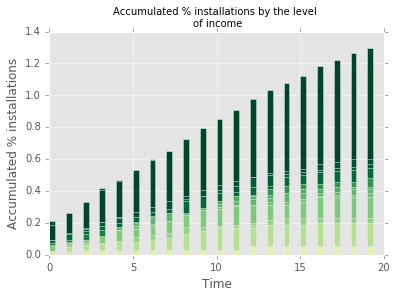

In [77]:
fig, host = plt.subplots()

ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

norm = matplotlib.colors.Normalize(vmin=0, vmax=N_INCOME_BINS - 1)
cmap_custom = cm.get_cmap('YlGn')
incomes = norm(range(N_INCOME_BINS))
colors = []

for income_ in incomes:
    colors.append(cmap_custom(income_))


p1 = host.bar(ind, ticks_income_penetration_acc[:, 0], width, color=colors[0])

for income_bin in range(1, N_INCOME_BINS, 1):
    p2 = host.bar(ind, ticks_income_penetration_acc[:, income_bin], width, color=colors[income_bin], \
                  bottom=ticks_income_penetration_acc[:, income_bin - 1])


host.set_xlabel("Time")
host.set_ylabel("Accumulated % installations")
host.set_title('Accumulated % installations by the level \n of income', fontsize=10)

plt.savefig('Simulation_results4_' + data_mode + '.png', dpi=300)
plt.show()

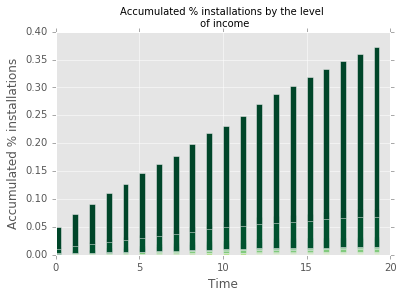

In [76]:
fig, host = plt.subplots()

ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


norm = matplotlib.colors.Normalize(vmin=0, vmax=N_INCOME_BINS - 1)
cmap_custom = cm.get_cmap('YlGn')
incomes = norm(range(N_INCOME_BINS))
colors = []

for income_ in incomes:
    colors.append(cmap_custom(income_))


p1 = host.bar(ind, ticks_income_penetration_acc[:, 0], width, color=colors[0])

for income_bin in range(1, N_INCOME_BINS, 1):
    p2 = host.bar(ind, ticks_income_penetration_acc_total[:, income_bin], width, color=colors[income_bin], \
                  bottom=ticks_income_penetration_acc_total[:, income_bin - 1])


host.set_xlabel("Time")
host.set_ylabel("Accumulated % installations")
host.set_title('Accumulated % installations by the level \n of income', fontsize=10)

plt.savefig('Simulation_results5_' + data_mode + '.png', dpi=300)
plt.show()

## Graph for distribution of installations in time 

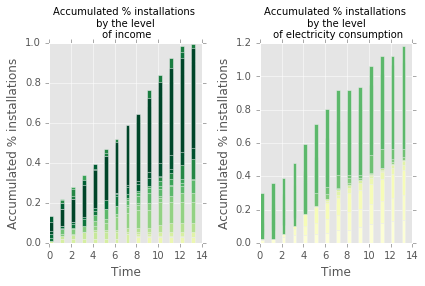

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(bottom=0.25)




ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

norm = matplotlib.colors.Normalize(vmin=0, vmax=N_BINS_INCOME - 1)
cmap_custom = cm.get_cmap('YlGn')
incomes = norm(range(N_BINS_INCOME))
colors_income = []

for income_ in incomes:
    colors_income.append(cmap_custom(income_))


p1 = axes[0].bar(ind[0:N_TICKS_DISPLAY - 1], ticks_income_penetration_acc[:, 0][0:N_TICKS_DISPLAY - 1], width, color=colors_income[0])

for bin_ in range(1, N_BINS_INCOME, 1):
    p2 = axes[0].bar(ind[0:N_TICKS_DISPLAY - 1], \
                     ticks_income_penetration_acc[:, bin_][0:N_TICKS_DISPLAY - 1], \
                     width, color=colors_income[bin_], \
                  bottom=ticks_income_penetration_acc[:, bin_ - 1][0:N_TICKS_DISPLAY - 1])


axes[0].set_xlabel("Time")
axes[0].set_ylabel("Accumulated % installations")
axes[0].set_title('Accumulated % installations \n by the level \n of income', fontsize=10)


elects = norm(range(N_BINS_ELECT))
colors_elect = []



for elect_ in elects:
    colors_elect.append(cmap_custom(elect_))


p1 = axes[1].bar(ind[0:N_TICKS_DISPLAY - 1], ticks_elect_penetration_acc[:, 0][0:N_TICKS_DISPLAY - 1], width, color=colors_elect[0])

for bin_ in range(1, N_BINS_ELECT, 1):
    p2 = axes[1].bar(ind[0:N_TICKS_DISPLAY - 1], ticks_elect_penetration_acc[:, bin_][0:N_TICKS_DISPLAY - 1], \
                     width, color=colors_income[bin_], \
                  bottom=ticks_elect_penetration_acc[:, bin_ - 1][0:N_TICKS_DISPLAY - 1])


    
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Accumulated % installations")
axes[1].set_title('Accumulated % installations \n by the level \n of electricity consumption', fontsize=10)
    

plt.tight_layout()
plt.savefig('Simulation_results_dist_' + data_mode + '.png', dpi=300)
plt.show()


## Decision rules

In [37]:
theta = np.array([1.0, 3.0, 0.02, 0.5])

In [43]:
def p_switch(I, irr):
    p = 1 / (1 + math.exp(- (irr * theta[3] - 1 / (theta[1]) * math.pow(1 + theta[0]/theta[1] * I / 1000, - 1 / (1 + theta[0])))/ (theta[2])))
    if (p > 1.0):
        p = 1.0
    return p

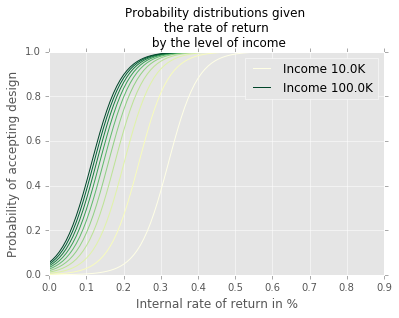

In [137]:
fig, host = plt.subplots()


N_BINS = 10

Is = np.linspace(10000, 100000, num=N_BINS)
irrs = np.linspace(0.0, 0.9, num=100)
y = np.zeros((10,100))

i = 0
for I in Is:
    j = 0
    for irr in irrs:
        y[i, j] = p_switch(I, irr)
        j = j + 1
    i = i + 1

lines = []


norm = matplotlib.colors.Normalize(vmin=0, vmax=N_BINS - 1)
cmap_custom = cm.get_cmap('YlGn')
incomes = norm(range(N_BINS))
colors = []

for income_ in incomes:
    colors.append(cmap_custom(income_))

for i in range(10):
    lines.append(host.plot(irrs, y[i], color=colors[i])[0])

lines_to_show = [lines[0], lines[-1]]
labels = ["{}{}{}".format(*items) for items in zip(['Income '] * len(Is), Is/1000, ['K'] * len(Is))]
labels_to_show = [labels[0], labels[-1]]


host.legend(lines_to_show, labels_to_show)


host.set_xlabel("Internal rate of return in %")
host.set_ylabel("Probability of accepting design")
host.set_title('Probability distributions given \n the rate of return \n by the level of income', fontsize=10)

plt.tight_layout()
plt.savefig('Simulation_results6_' + 'general' + '.png', dpi=300)

plt.show()



## How to draw graphs below
[1](http://matplotlib.org/1.4.1/examples/ticks_and_spines/spines_demo_bounds.html)
[2](http://matplotlib.org/1.4.1/examples/pylab_examples/multiple_yaxis_with_spines.html)
[3](http://matplotlib.org/api/markers_api.html#module-matplotlib.markers)
[4](http://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes.plot)

## Dynamics of installations

In [13]:
N_TICKS_DISPLAY = 15

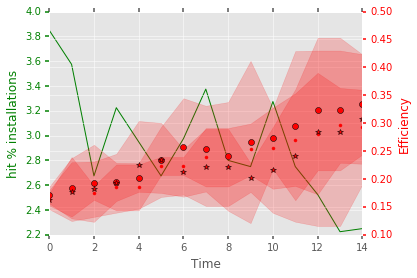

In [61]:


fig, host = plt.subplots()
fig.subplots_adjust(right=0.85)

par1 = host.twinx()


p1, = host.plot(df.index.values[0:N_TICKS_DISPLAY], df['N_installed'][0:N_TICKS_DISPLAY]/1000*100, "g-", label="% installations")
p2, = par1.plot(df.index.values[0:N_TICKS_DISPLAY], df['sei_0'][0:N_TICKS_DISPLAY], "ro", label="Efficiency")
par1.plot(df.index.values[0:N_TICKS_DISPLAY], df['sei_1'][0:N_TICKS_DISPLAY], "r.")
par1.plot(df.index.values[0:N_TICKS_DISPLAY], df['sei_2'][0:N_TICKS_DISPLAY], "r*")

par1.fill_between(df.index.values[0:N_TICKS_DISPLAY], 
                  df['sei_0'][0:N_TICKS_DISPLAY]-2*df_std['sei_0'][0:N_TICKS_DISPLAY], 
                  df['sei_0'][0:N_TICKS_DISPLAY]+2*df_std['sei_0'][0:N_TICKS_DISPLAY], 
                  color='r', 
                  alpha=0.2)

par1.fill_between(df.index.values[0:N_TICKS_DISPLAY], 
                  df['sei_1'][0:N_TICKS_DISPLAY]-2*df_std['sei_1'][0:N_TICKS_DISPLAY], 
                  df['sei_1'][0:N_TICKS_DISPLAY]+2*df_std['sei_1'][0:N_TICKS_DISPLAY], 
                  color='r', 
                  alpha=0.2)

par1.fill_between(df.index.values[0:N_TICKS_DISPLAY], 
                  df['sei_2'][0:N_TICKS_DISPLAY]-2*df_std['sei_2'][0:N_TICKS_DISPLAY], 
                  df['sei_2'][0:N_TICKS_DISPLAY]+2*df_std['sei_2'][0:N_TICKS_DISPLAY], 
                  color='r', 
                  alpha=0.2)


host.set_xlabel("Time")
host.set_ylabel("hit % installations")
par1.set_ylabel("Efficiency")


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())


tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]

#host.legend(lines, [l.get_label() for l in lines])
plt.savefig('Simulation_results1_' + data_mode + '.png', dpi=300)
plt.show()



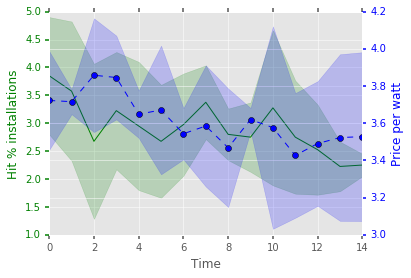

In [62]:
fig, host = plt.subplots()
fig.subplots_adjust(right=0.85)

par1 = host.twinx()


p1, = host.plot(df.index.values[0:N_TICKS_DISPLAY], df['N_installed'][0:N_TICKS_DISPLAY]/1000*100, "g-", label="% installations")
p2, = par1.plot(df.index.values[0:N_TICKS_DISPLAY], df['P_av'][0:N_TICKS_DISPLAY], "--bo", label="Price")

#add +- 2 std
host.fill_between(df.index.values[0:N_TICKS_DISPLAY], 
                  df['N_installed'][0:N_TICKS_DISPLAY]/1000*100-2*df_std['N_installed'][0:N_TICKS_DISPLAY]/1000*100, 
                  df['N_installed'][0:N_TICKS_DISPLAY]/1000*100+2*df_std['N_installed'][0:N_TICKS_DISPLAY]/1000*100, 
                  color='g', 
                  alpha=0.2)

par1.fill_between(df.index.values[0:N_TICKS_DISPLAY], 
                 df['P_av'][0:N_TICKS_DISPLAY]-2*df_std['P_av'][0:N_TICKS_DISPLAY],
                 df['P_av'][0:N_TICKS_DISPLAY]+2*df_std['P_av'][0:N_TICKS_DISPLAY],
                  color='b', 
                  alpha=0.2)

host.set_xlabel("Time")
host.set_ylabel("Hit % installations")
par1.set_ylabel("Price per watt")


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())


tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]

#host.legend(lines, [l.get_label() for l in lines])
plt.savefig('Simulation_results2_' + data_mode + '.png', dpi=300)
plt.show()

## Number of installations per income level

# Run number of simulations with different seeds

In [ ]:
#change back to starting directory so that all relative code works

In [ ]:
%cd /Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model

In [16]:
#read setup file and change seed
data_mode = 'CA'
file = '../../ABMIRISLab/Source/Examples/EEModel/w.json'
file = '/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Examples/EEModel/' + data_mode + '/w.json'


mode="NEW"
model_file="/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Examples/EEModel/" + data_mode + "/eemodel.model"
    
with open(file) as infile:
    w_setup = json.load(infile)
    
for seed in (2016, 2015, 2014, 2012):
    w_setup['SEED'] = seed
    with open(file, 'w') as outfile:
        json.dump(w_setup, outfile)
        
    #run simulation 
    %cd /Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
    !./SolarEE $mode $model_file
    %cd /Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model

/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Thu 2017-01-12 07:57:38  INFO: started running
time: Thu 2017-01-12 07:57:45  INFO: stopped running
/Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model
/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Thu 2017-01-12 07:58:09  INFO: started running
time: Thu 2017-01-12 07:58:16  INFO: stopped running
/Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model
/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Thu 2017-01-12 07:58:38  INFO: started running
time: Thu 2017-01-12 07:58:43  INFO: stopped running
/Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model
/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Thu 2017-01-12 07:59:04  INFO: started running
time: Thu 2017-01-

In [ ]:
%lsmagic

In [18]:
#read setup file and change seed
data_mode = 'MT'
file = '../../ABMIRISLab/Source/Examples/EEModel/w.json'
file = '/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Examples/EEModel/' + data_mode + '/w.json'


mode="NEW"
model_file="/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Examples/EEModel/" + data_mode + "/eemodel.model"
    
with open(file) as infile:
    w_setup = json.load(infile)
    
for seed in (2016, 2015, 2014, 2012):
    w_setup['SEED'] = seed
    with open(file, 'w') as outfile:
        json.dump(w_setup, outfile)
        
    #run simulation 
    %cd /Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
    !./SolarEE $mode $model_file
    %cd /Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model

/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Thu 2017-01-12 08:32:49  INFO: started running
time: Thu 2017-01-12 08:32:54  INFO: stopped running
/Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model
/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Thu 2017-01-12 08:33:14  INFO: started running
time: Thu 2017-01-12 08:33:21  INFO: stopped running
/Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model
/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Thu 2017-01-12 08:33:41  INFO: started running
time: Thu 2017-01-12 08:33:46  INFO: stopped running
/Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model
/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Thu 2017-01-12 08:34:06  INFO: started running
time: Thu 2017-01-